<a href="https://colab.research.google.com/github/ouaguenouni/GaussianProcessesForPreferences/blob/main/BayesianLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pymc aesara numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 17.1 MB/s eta 0:00:00


In [3]:

# Standard imports
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)
import pymc.sampling_jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from itertools import combinations
import torch
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import os, sys
sys.stderr = open(os.devnull, "w")
import pymc as pm
import aesara.tensor as at
import aesara

In [5]:

def singletons_and_pairs(lst):
    singletons = [(x,) for x in lst]
    pairs = list(combinations(lst, 2))
    return singletons + pairs

def sample_w(model):
    w = np.random.normal(0, 1, size = (len(model),))
    p = np.random.randint(0, 2, size = (len(model),))
    w = w * p
    return w

def vectorize_smoothie(smoothie):
    arr = np.zeros(len(model))
    for i in range(arr.shape[0]):
        if all(j in list(smoothie) for j in model[i]):
            arr[i] = 1
    return arr

def f(smoothie, w):
    return torch.tensor(vectorize_smoothie(smoothie))@w

def cdf(z):
    return 0.5 * (1.0 + torch.erf(z / torch.sqrt(torch.tensor(2.0))))

def random_subset(input_list):
    k = random.randint(1, len(input_list))
    return "".join(sorted(random.sample(input_list, k)))

ingredients = ["o", "a", "b","l", "m"]
model = singletons_and_pairs(ingredients)


In [6]:


def sample_dataset(n):
    ingredients = ["o", "a", "b","l", "m"]
    model = singletons_and_pairs(ingredients)
    X = []
    y = []
    w = sample_w(model)
    subsets = set()
    while len(subsets) != n:
        s = random_subset(ingredients)
        subsets.add(s)
    subsets = list(subsets)
    for i in range(len(subsets)-1):
        x_i = vectorize_smoothie(subsets[i])
        for j in range(i+1, len(subsets)):
            x_j = vectorize_smoothie(subsets[j])
            x1 = x_i - x_j
            x2 = x_j - x_i
            if f(subsets[i], w) == f(subsets[j], w):
                continue
            if f(subsets[i], w) > f(subsets[j], w):
                X.append(x1)
                X.append(x2)
                y.append(1)
                y.append(0)
                continue
            if f(subsets[i], w) < f(subsets[j], w):
                X.append(x1)
                X.append(x2)
                y.append(0)
                y.append(1)
                continue
    X = np.array(X)
    y = np.array(y)
    return X,y,w,model

In [7]:
ingredients = ["o", "a", "b","l", "m"]
model = singletons_and_pairs(ingredients)
sample_w(model)
X,y,w_true,true_model = sample_dataset(30)

In [22]:
X

array([[ 1.,  0., -1., ..., -1., -1., -1.],
       [-1.,  0.,  1., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  0., -1.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [56]:
with pm.Model() as probit_model:

    #Hyper-priors
    tau_0 = pm.HalfNormal('tau_0', sigma=30)
    tau_1 = pm.HalfNormal('tau_1', sigma=30)


    # Priors for weights and bias
    weights = pm.Normal('weights', mu = 0, sigma = tau_0, shape=X.shape[1])
    bias = pm.Normal('bias',mu = 0, sigma = tau_1)

    # Probit link function
    mu = pm.math.dot(X, weights) + bias
    phi = pm.math.invprobit(mu)  # Inverse probit link function

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=phi, observed=y)

    # Sample from the posterior
    #trace = pm.sampling_jax.sample_numpyro_nuts(4000, tune=500, chains=2, target_accept = 0.95)
    trace = pm.sample(1500, tune=500, chains=5, target_accept = 0.95)

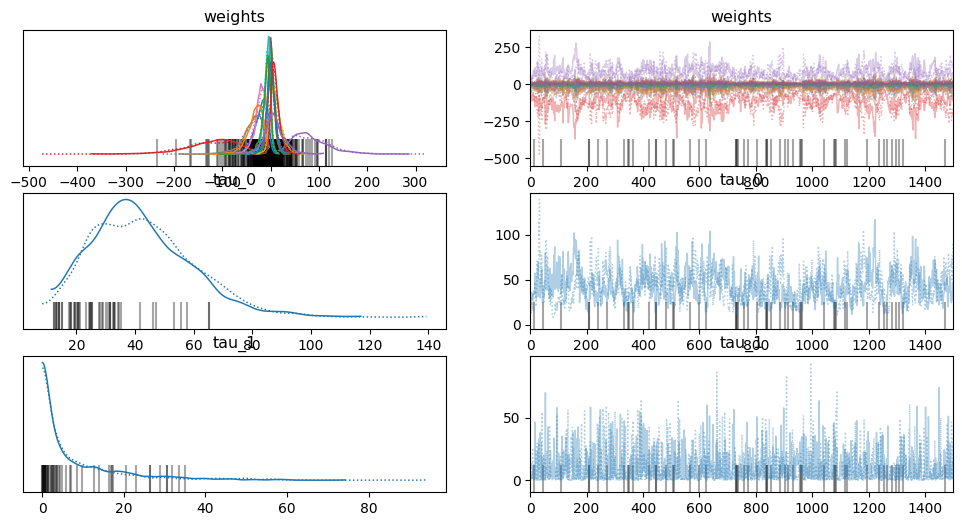

In [59]:
pm.plot_trace(trace, var_names=['weights', "tau_0", "tau_1"])
plt.savefig("trace.png")

In [48]:
def trace_to_numpy(trace):
    numpy_trace = {}
    for var in trace.posterior.data_vars.keys():
        numpy_trace[var] = trace.posterior[var].values
    return np.concatenate([numpy_trace["weights"], numpy_trace["bias"].reshape((2,-1,1))], axis = 2)

In [51]:
numpy_trace = trace_to_numpy(trace)

In [52]:
numpy_trace.shape

(2, 1500, 16)

In [60]:
with pm.Model() as probit_model:

    # Priors for weights and bias
    weights = pm.Normal('weights', mu = 0, sigma = 3, shape=X.shape[1])
    bias = pm.Normal('bias',mu = 0, sigma = 3)

    # Probit link function
    mu = pm.math.dot(X, weights) + bias
    phi = pm.math.invprobit(mu)  # Inverse probit link function

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=phi, observed=y)

    # Sample from the posterior
    #trace = pm.sampling_jax.sample_numpyro_nuts(4000, tune=500, chains=2, target_accept = 0.95)
    trace = pm.sample(1500, tune=500, chains=5, target_accept = 0.95)

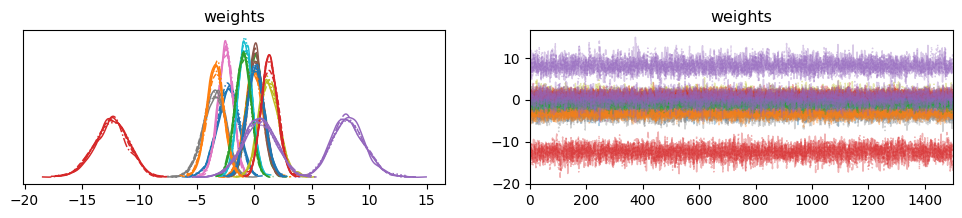

In [61]:
pm.plot_trace(trace, var_names=['weights'])
plt.savefig("trace.png")